In [642]:
import pyforest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import graphviz
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [643]:
train = pd.read_csv('/Users/karanam.rama/Downloads/titanic_train.csv')
test = pd.read_csv('/Users/karanam.rama/Downloads/titanic_test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# checking the data completeness




In [647]:
train.isnull().sum()
# Age, Cabin and Embarked columns have null values

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
title          0
dtype: int64

In [648]:
test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
title          0
dtype: int64

# Data Cleaning

# filling null values

In [646]:
# Adding title column
train['title'] = train['Name'].apply(lambda x : x.split(',')[1].strip().split('.')[0])
test['title'] = test['Name'].apply(lambda x : x.split(',')[1].strip().split('.')[0])

# filling null values of Age column
train['Age'] = train.groupby('title')['Age'].transform(lambda x : x.fillna(x.mean()))
test['Age'] = test.groupby('title')['Age'].transform(lambda x : x.fillna(x.mean()))

# filling null values of Age column
train['Age'] = train.groupby('Sex')['Age'].transform(lambda x : x.fillna(x.mean()))
test['Age'] = test.groupby('Sex')['Age'].transform(lambda x : x.fillna(x.mean()))

def mod_title(y):
    if  y not in ('Mr','Miss','Mrs','Master') :
        return 'rare'
    else :
        return y
train['title'] = train['title'].apply(lambda x : mod_title(x))
test['title'] = test['title'].apply(lambda x : mod_title(x))


# filling null values of embarked column with the most common embarked station
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].value_counts().index[0])


# filling null value of Fare column in test data
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

# precision handling for fare column
test['Fare'] = test['Fare'].round(decimals =1)
train['Fare'] = train['Fare'].round(decimals =1)

train['Cabin'] = train['Cabin'].fillna('no')
test['Cabin'] = test['Cabin'].fillna('no')

def change_cabin(y):
    if y != 'no':
        return 'yes'
    else :
        return 'no'
train['Cabin'] = train['Cabin'].apply(lambda x : change_cabin(x))    
test['Cabin'] = test['Cabin'].apply(lambda x : change_cabin(x))

# Data Analysis

# Feature Engineering

In [649]:

# classifying the age
train['age_cat'] = pd.cut(train['Age'],bins = [-1,18,30,45,100],labels =['age1','age2','age3','age4'])
test['age_cat'] = pd.cut(test['Age'],bins = [-1,18,30,45,100],labels =['age1','age2','age3','age4'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [650]:
# creating a new column combining sex and Passenger class
def sex_class(x):
    if x['Sex'] == 'female':
        if x['Pclass'] == 1 :
            return 'female_1'
        elif x['Pclass'] == 2 :
            return 'female_2'
        else :
            return 'female_3'
    else :
        if x['Pclass'] == 1 :
            return 'male_1'
        elif x['Pclass'] == 2 :
            return 'male_2'
        else :
            return 'male_3' 
train['newc'] = train.apply(lambda x : sex_class(x),axis =1)
test['newc'] = test.apply(lambda x : sex_class(x),axis =1)

In [651]:
# getting the ticket count

train1 = train
test1 = test
train1 = train1.drop(['Survived'],axis =1)
total_df = pd.concat([test1,train1])
ticket_df = total_df['Ticket'].value_counts()
ticket_df = ticket_df.reset_index()
ticket_df.columns = ['ticket','total_count']
ticket_df.head()

<IPython.core.display.Javascript object>

,ticket,total_count
0,CA. 2343,11
1,1601,8
2,CA 2144,8
3,S.O.C. 14879,7
4,3101295,7


In [652]:
# creating new column -- fare per each passeneger  for training data 
train = train.merge(ticket_df,how = 'left',left_on='Ticket',right_on='ticket')
train['per_fare'] = train['Fare']/train['total_count']
train['per_fare'] = train['per_fare'].round(1)

# creating new column -- fare per each passeneger  for test data 
test = test.merge(ticket_df,how = 'left',left_on='Ticket',right_on='ticket')
test['per_fare'] = test['Fare']/test['total_count']
test['per_fare'] = test['per_fare'].round(1)

# classifying the fare
train['fare_cat'] = pd.cut(train['per_fare'],bins = [-1,10,20,200],labels =['fare_1','fare_2','fare_3'])
test['fare_cat'] = pd.cut(test['per_fare'],bins = [-1,10,20,200],labels =['fare_1','fare_2','fare_3'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [653]:
# calculating the percentage of survival
train['count_1'] = train.groupby('Ticket')['Survived'].transform(lambda x : x.sum())
train['per_surv'] = train['count_1'].div(train['total_count'])
train['train_count'] = train.groupby('Ticket')['Survived'].transform(lambda x : x.count())
test['test_count'] = test.groupby('Ticket')['Fare'].transform(lambda x : x.count())
train['per_surv_train'] = train['count_1']/train['train_count']

In [654]:
for i in train.index :
    if train['total_count'][i] == train['train_count'][i]:
        train['per_surv_train'][i] = 0.5

<ipython-input-654-95194bde35be>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [655]:
# creating a dictionary with ticket as keys and survival_percentage as values
d = {}
for i in train.index :
    if (train['Ticket'][i] not in d.keys()) & (train['total_count'][i]!= train['train_count'][i]):  
        d[train['Ticket'][i]] = train['per_surv_train'][i]
        
# using this dictionary to define survival_percentage of the family members in test dataset


In [656]:
test['per_surv_train'] = 0.5
for i in test.index :
    if test['total_count'][i] != test['test_count'][i]:
        test['per_surv_train'][i] = d[test['Ticket'][i]]

<ipython-input-656-ff78a0a199e9>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [657]:
test.dtypes

PassengerId          int64
Pclass               int64
Name                object
Sex                 object
Age                float64
SibSp                int64
Parch                int64
Ticket              object
Fare               float64
Cabin               object
Embarked            object
title               object
age_cat           category
newc                object
ticket              object
total_count          int64
per_fare           float64
fare_cat          category
test_count         float64
per_surv_train     float64
dtype: object

In [658]:
train.dtypes

PassengerId          int64
Survived             int64
Pclass               int64
Name                object
Sex                 object
Age                float64
SibSp                int64
Parch                int64
Ticket              object
Fare               float64
Cabin               object
Embarked            object
title               object
age_cat           category
newc                object
ticket              object
total_count          int64
per_fare           float64
fare_cat          category
count_1              int64
per_surv           float64
train_count          int64
per_surv_train     float64
dtype: object

In [638]:
px.histogram(test,x ='per_surv_train',color = 'total_count')

<IPython.core.display.Javascript object>

In [584]:
px.histogram(train,x = 'per_surv_train',color ='total_count')

<IPython.core.display.Javascript object>

In [585]:
train[train['total_count']==1].shape

(481, 23)

In [659]:
#  encoding  of category column 
features = ['title','fare_cat','age_cat','newc']
train_df = train.merge(pd.get_dummies(train[features]),how ='inner',left_index=True,right_index=True)
test_df = test.merge(pd.get_dummies(test[features]),how ='inner',left_index=True,right_index=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [483]:
train_df = train_df[train_df['total_count'] == train_df['train_count']]

In [507]:
train_df = train_df[train_df['total_count'] == 1]

In [660]:
train_df.shape

(891, 41)

In [661]:
train_df.dtypes

PassengerId           int64
Survived              int64
Pclass                int64
Name                 object
Sex                  object
Age                 float64
SibSp                 int64
Parch                 int64
Ticket               object
Fare                float64
Cabin                object
Embarked             object
title                object
age_cat            category
newc                 object
ticket               object
total_count           int64
per_fare            float64
fare_cat           category
count_1               int64
per_surv            float64
train_count           int64
per_surv_train      float64
title_Master          uint8
title_Miss            uint8
title_Mr              uint8
title_Mrs             uint8
title_rare            uint8
fare_cat_fare_1       uint8
fare_cat_fare_2       uint8
fare_cat_fare_3       uint8
age_cat_age1          uint8
age_cat_age2          uint8
age_cat_age3          uint8
age_cat_age4          uint8
newc_female_1       

In [673]:
test_df.dtypes

PassengerId           int64
Pclass                int64
Name                 object
Sex                  object
Age                 float64
SibSp                 int64
Parch                 int64
Ticket               object
Fare                float64
Cabin                object
Embarked             object
title                object
age_cat            category
newc                 object
ticket               object
total_count           int64
per_fare            float64
fare_cat           category
test_count          float64
per_surv_train      float64
title_Master          uint8
title_Miss            uint8
title_Mr              uint8
title_Mrs             uint8
title_rare            uint8
fare_cat_fare_1       uint8
fare_cat_fare_2       uint8
fare_cat_fare_3       uint8
age_cat_age1          uint8
age_cat_age2          uint8
age_cat_age3          uint8
age_cat_age4          uint8
newc_female_1         uint8
newc_female_2         uint8
newc_female_3         uint8
newc_male_1         

In [663]:
feature_names = ['newc_female_1','newc_female_2','newc_female_3','newc_male_1','newc_male_2','newc_male_3','title_Miss','title_Mr','title_Mrs','fare_cat_fare_1','fare_cat_fare_2','fare_cat_fare_3','title_rare','title_Master','age_cat_age1','age_cat_age2','age_cat_age3','age_cat_age4','per_surv_train'] 
xtrain,xvalid,ytrain,yvalid = train_test_split(train_df[feature_names],train_df['Survived'],test_size = 0.3, stratify=train_df['Survived'],random_state=35)
# xtest = test_df[feature_names]

<IPython.core.display.Javascript object>

In [664]:
# for grid search 
X = train_df[feature_names]
Y = train_df['Survived']

In [665]:
#KNN CLASSIFIER
knn = KNeighborsClassifier()
# knn.fit(xtrain,ytrain)
# sub = knn.predict(xvalid)
# print(f'accuracy_score : {accuracy_score(yvalid,sub)}')
# print(f'auc_roc_score : {roc_auc_score(yvalid,sub)}')

In [666]:
# Tuning of KNN Classifier
param_grid  = dict(n_neighbors = list(range(1,31)), weights = ['uniform','distance'],algorithm = ['auto','ball_tree', 'kd_tree', 'brute'])
grid = GridSearchCV(knn,param_grid,cv=10,scoring ='accuracy',n_jobs= -1)
grid.fit(xtrain,ytrain)
print(grid.best_params_)
print(grid.best_score_)

{'algorithm': 'brute', 'n_neighbors': 9, 'weights': 'distance'}
0.8459549411162314


In [667]:
# Decision Tree
dc = DecisionTreeClassifier()
dc.fit(xtrain,ytrain)
sub = dc.predict(xvalid)
print(f'accuracy_score : {accuracy_score(yvalid,sub)}')
print(f'auc_roc_score : {roc_auc_score(yvalid,sub)}')

accuracy_score : 0.8432835820895522
auc_roc_score : 0.8143571638717271


In [668]:
# Grid Search for Decision Tree
param_grid = dict(criterion = ['gini','entropy'],min_samples_leaf = list(range(2,20)))
grid = GridSearchCV(dc,param_grid,cv=10,scoring ='accuracy',n_jobs= -1)
grid.fit(X,Y)
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'gini', 'min_samples_leaf': 7}
0.8394881398252185


In [669]:
rfc = RandomForestClassifier(n_jobs = -1)
param_grid = dict(n_estimators = list(range(10,100,10)), criterion = ['gini','entropy'],min_samples_leaf = list(range(2,11)))
grid = GridSearchCV(rfc,param_grid,cv = 10, scoring='accuracy',n_jobs = -1)
grid.fit(X,Y)
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'gini', 'min_samples_leaf': 6, 'n_estimators': 10}
0.8406242197253434


In [689]:
lgbmc = LGBMClassifier()
param_grid = dict(n_estimators = list(range(10,100,10)), boosting_type = ['dart','gbdt'],min_child_samples = list(range(2,11)))
grid = GridSearchCV(lgbmc,param_grid,cv = 10, scoring='accuracy',n_jobs = -1)
grid.fit(X,Y)
print(grid.best_params_)
print(grid.best_score_)

{'boosting_type': 'dart', 'min_child_samples': 10, 'n_estimators': 20}
0.8417353308364544


In [678]:
# Light GBM classifier
lgbmc = LGBMClassifier(boosting_type='dart')
lgbmc.fit(xtrain,ytrain)
sub = lgbmc.predict(xvalid)
print('accuracy_score - ',accuracy_score(sub,yvalid))
print('auc_roc_score - ', roc_auc_score(yvalid,sub))

accuracy_score -  0.8507462686567164
auc_roc_score -  0.8295380994410122


In [674]:
rfc = RandomForestClassifier(criterion=  'gini', min_samples_leaf = 6, n_estimators =  10)
rfc.fit(X,Y)
sub = rfc.predict(test_df[feature_names])

In [690]:
lgbmc = LGBMClassifier(boosting_type ='dart',min_child_samples=10,n_estimators=20)
lgbmc.fit(X,Y)
sub = lgbmc.predict(test_df[feature_names])

In [685]:
sub =lgbmc.predict(test_df[feature_names])

In [692]:
df_sub = test_df[['PassengerId','Age']]
df_sub['Survived'] = sub
df_sub = df_sub.drop(['Age'],axis =1)
df_sub.to_csv('/Users/karanam.rama/Downloads/my_submission1.csv',index =False)

<ipython-input-692-d80d6688a63e>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



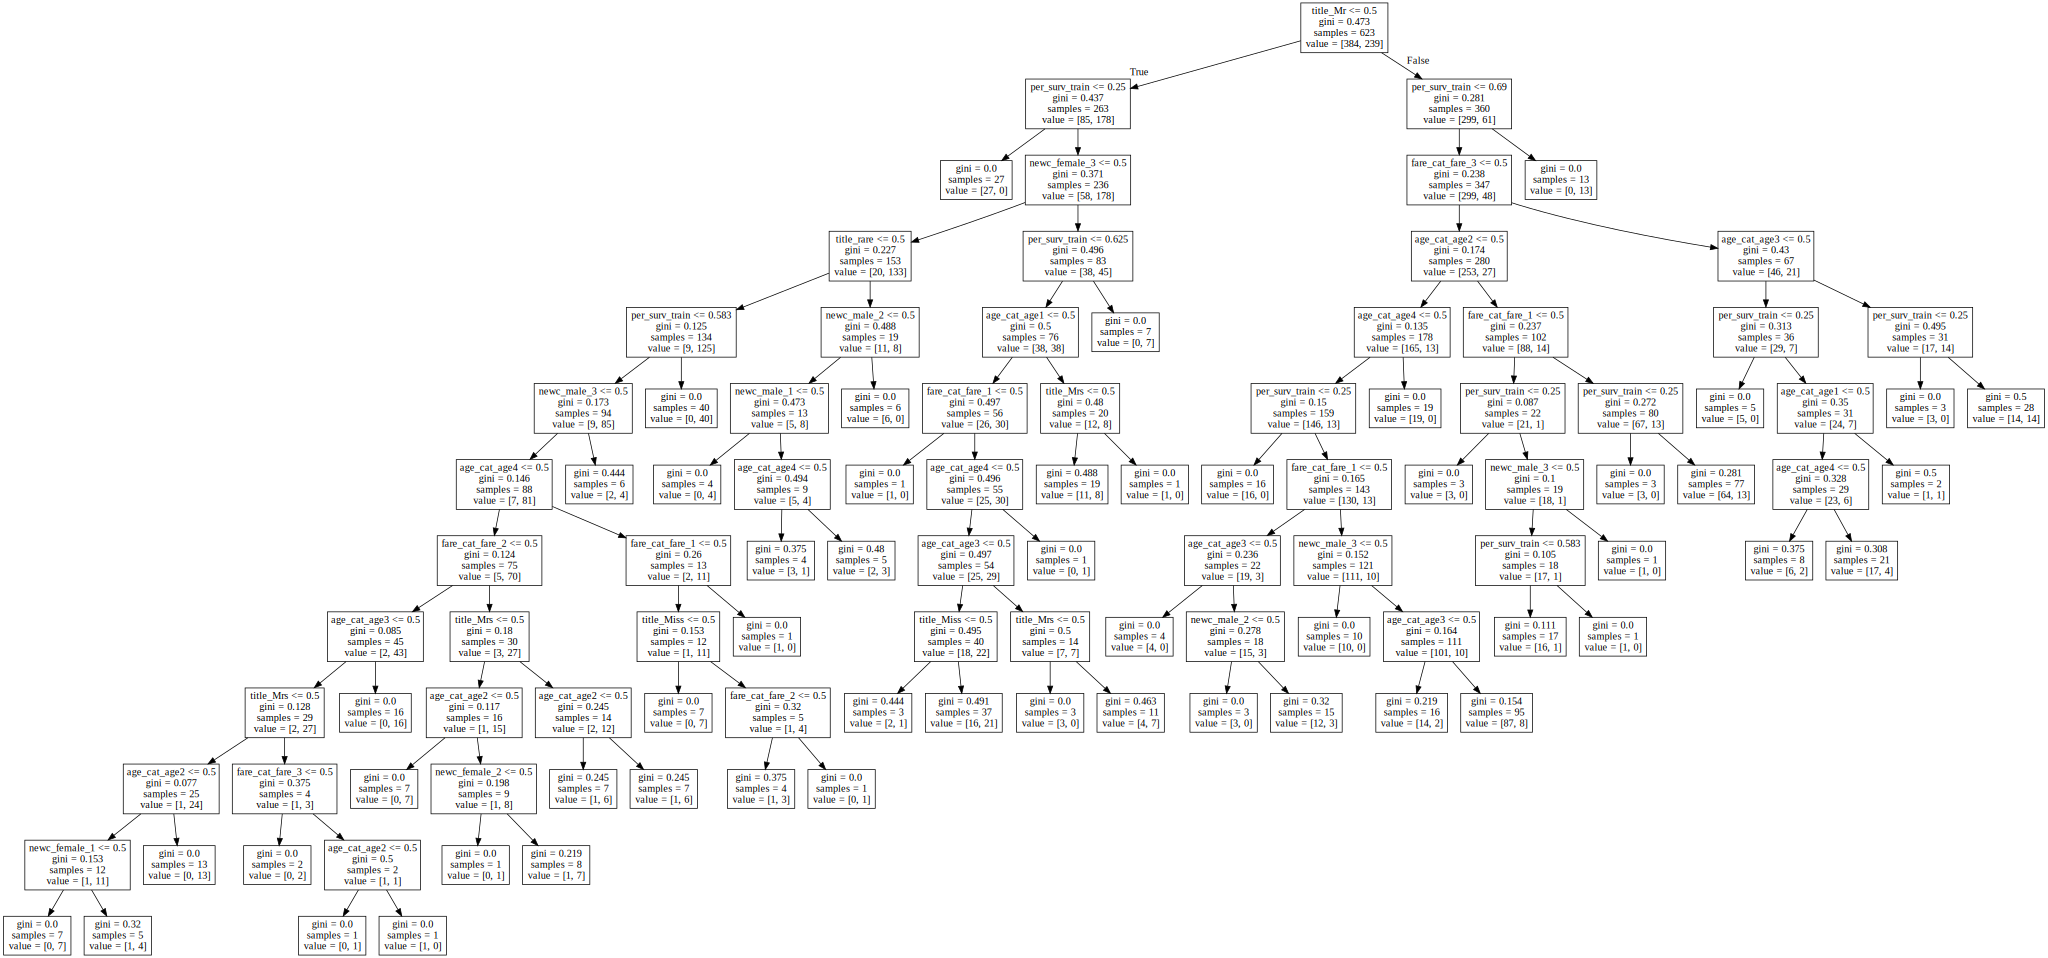

In [588]:
from sklearn import tree
tree_graph = tree.export_graphviz(dc, out_file=None, feature_names=feature_names)
graphviz.Source(tree_graph)